In [3]:
import xarray as xr
import glob
import os

# --- USER CONFIGURATION ---
FOLDER_PATH = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_LLJ/'
FILE_PATTERN = '*.nc'

# Find the first file to use as a sample
search_path = os.path.join(FOLDER_PATH, FILE_PATTERN)
files = sorted(glob.glob(search_path))

if not files:
    print("No files found. Please check your path.")
else:
    sample_file = files[0]
    print(f"Inspecting Metadata from: {os.path.basename(sample_file)}\n")

    try:
        with xr.open_dataset(sample_file) as ds:
            
            # --- 1. DEEP DIVE INTO 'llj_flag' ---
            if 'llj_flag' in ds:
                print("="*40)
                print("DETAILED INFO FOR: llj_flag")
                print("="*40)
                
                # Print all attributes (Description, Units, Flag Meanings)
                for attr, value in ds['llj_flag'].attrs.items():
                    print(f"{attr:15}: {value}")
                    
                # specific check for flag meanings (often space-separated strings)
                if 'flag_meanings' in ds['llj_flag'].attrs:
                    print("\nParsed Flag Meanings:")
                    meanings = ds['llj_flag'].attrs['flag_meanings'].split()
                    values = ds['llj_flag'].attrs.get('flag_values', range(len(meanings)))
                    for v, m in zip(values, meanings):
                        print(f"  Code {v}: {m}")
            else:
                print("Variable 'llj_flag' not found in this file.")

            # --- 2. DEEP DIVE INTO 'llj_class' (Likely Strength) ---
            if 'llj_class' in ds:
                print("\n" + "="*40)
                print("DETAILED INFO FOR: llj_class")
                print("="*40)
                for attr, value in ds['llj_class'].attrs.items():
                    print(f"{attr:15}: {value}")

            # --- 3. SUMMARY OF ALL VARIABLES ---
            print("\n" + "="*60)
            print(f"{'VARIABLE':<20} | {'DESCRIPTION / LONG NAME'}")
            print("="*60)
            
            for var_name in ds.data_vars:
                # Get long_name or description, fallback to standard_name or empty
                desc = ds[var_name].attrs.get('long_name', 
                       ds[var_name].attrs.get('description', 
                       ds[var_name].attrs.get('standard_name', '-')))
                
                # Truncate description if too long
                if len(desc) > 50: desc = desc[:47] + "..."
                
                print(f"{var_name:<20} | {desc}")

    except Exception as e:
        print(f"Error reading file: {e}")

Inspecting Metadata from: bloc.lidar.10min.z01.c1.20240202.181500.nc

DETAILED INFO FOR: llj_flag
units          : 1
long_name      : low level jet flag
ancillary_variables: qc_llj_flag

DETAILED INFO FOR: llj_class
units          : 1
long_name      : class of low level jet
ancillary_variables: qc_llj_class

VARIABLE             | DESCRIPTION / LONG NAME
u                    | mean W-E wind velocity
v                    | mean S-N wind velocity
w                    | mean vertical wind velocity
lat                  | Latitude
lon                  | Longitude
alt                  | Altitude
time_start           | start of the UTC time bin
time_end             | end of the UTC time bin
ws                   | mean horizontal wind speed
wd                   | mean wind direction
uu                   | W-E velocity variance
vv                   | S-N velocity variance
ww                   | vertical velocity variance
uv                   | horizontal (W-E to S-N) Reynolds stress
uw         

Found 520 files. Starting optimized processing...
Processing 1/520: bloc.lidar.10min.z01.c1.20240202.181500.nc
Processing 11/520: bloc.lidar.10min.z01.c1.20240218.000500.nc
Processing 21/520: bloc.lidar.10min.z01.c1.20240301.000500.nc
Processing 31/520: bloc.lidar.10min.z01.c1.20240311.000500.nc
Processing 41/520: bloc.lidar.10min.z01.c1.20240321.000500.nc
Processing 51/520: bloc.lidar.10min.z01.c1.20240331.000500.nc
Processing 61/520: bloc.lidar.10min.z01.c1.20240410.000500.nc
Processing 71/520: bloc.lidar.10min.z01.c1.20240422.000500.nc
Processing 81/520: bloc.lidar.10min.z01.c1.20240502.000500.nc
Processing 91/520: bloc.lidar.10min.z01.c1.20240512.000500.nc
Processing 101/520: bloc.lidar.10min.z01.c1.20240522.000500.nc
Processing 111/520: bloc.lidar.10min.z01.c1.20240601.000500.nc
Processing 121/520: bloc.lidar.10min.z01.c1.20240611.000500.nc
Processing 131/520: bloc.lidar.10min.z01.c1.20240621.000500.nc
Processing 141/520: bloc.lidar.10min.z01.c1.20240701.000500.nc
Processing 151/5

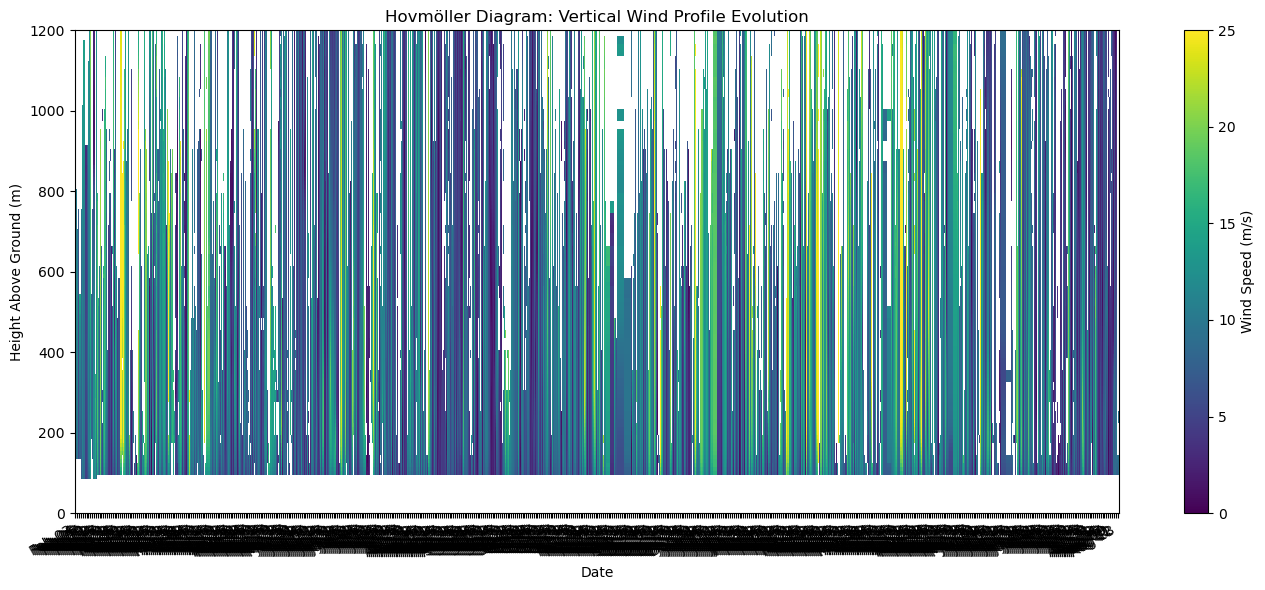

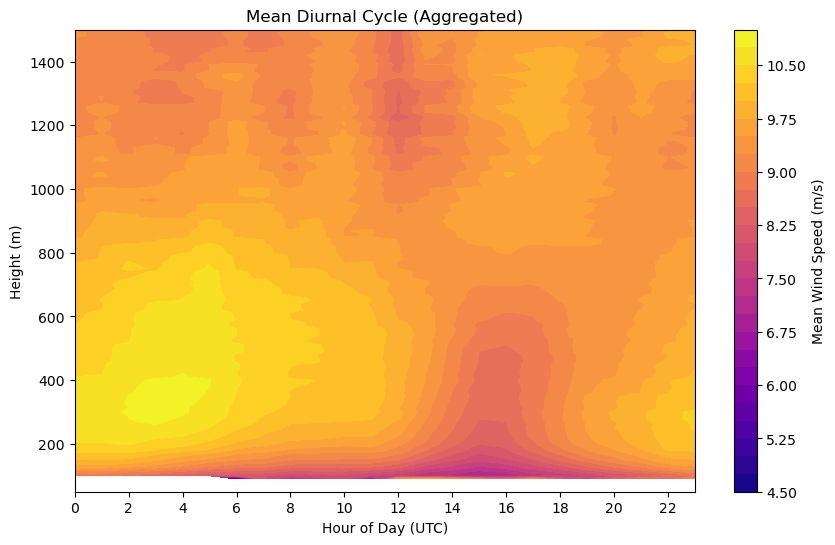

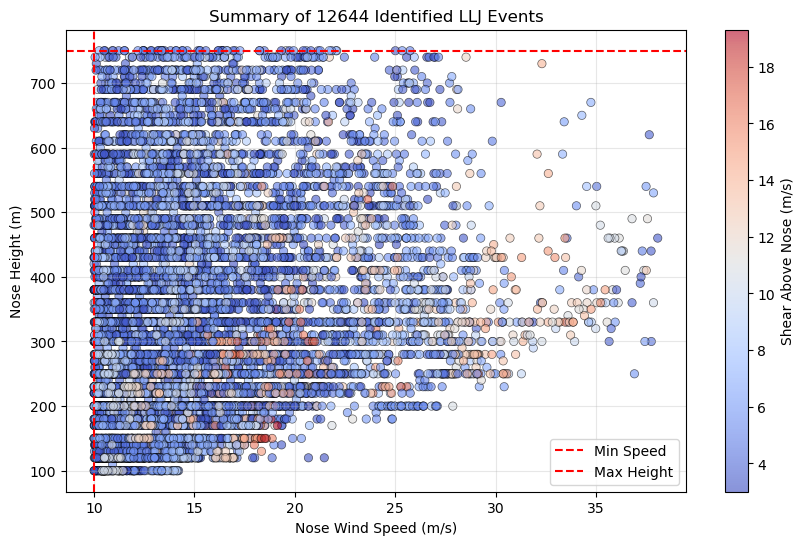

In [23]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --- USER CONFIGURATION ---
FOLDER_PATH = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BLOC_LLJ/'  
FILE_PATTERN = '*.nc'

# --- REFERENCE LOGIC CONSTANTS (from utils.py) ---
MIN_WS_THRESHOLD = 10.0       # m/s
MAX_NOSE_HEIGHT = 750.0       # meters
MIN_SHEAR_ABOVE = 3.0         # m/s
SEARCH_CEILING = 1000.0       # Search limit

def detect_jet_reference_logic(wspd_profile, heights):
    """
    Applies the EXACT physics logic to a single profile.
    """
    # 1. Subset to Search Region
    valid_mask = heights <= SEARCH_CEILING
    search_wspd = wspd_profile[valid_mask]
    search_hgt = heights[valid_mask]

    if len(search_wspd) == 0 or np.isnan(search_wspd).all():
        return False, np.nan, np.nan, np.nan

    # 2. Find Nose
    idx_max = np.nanargmax(search_wspd)
    ws_max = search_wspd[idx_max]
    nose_z = search_hgt[idx_max]

    # 3. Calculate Shear
    above_nose_wspd = wspd_profile[idx_max:]
    if len(above_nose_wspd) < 2:
        shear = 0.0
    else:
        min_above = np.nanmin(above_nose_wspd)
        shear = ws_max - min_above

    # 4. Apply Classification
    is_jet = False
    if (ws_max >= MIN_WS_THRESHOLD) and \
       (nose_z <= MAX_NOSE_HEIGHT) and \
       (shear >= MIN_SHEAR_ABOVE):
        is_jet = True

    return is_jet, ws_max, nose_z, shear

# --- INITIALIZATION ---
search_path = os.path.join(FOLDER_PATH, FILE_PATTERN)
file_list = sorted(glob.glob(search_path))

print(f"Found {len(file_list)} files. Starting optimized processing...")

# 1. Storage for Jet Statistics (The "df_jets")
all_jet_records = []

# 2. Storage for Hovmöller (We will save 1-Hour Averages only)
hovmoller_fragments = []

# 3. Storage for Diurnal Cycle (Running Sums)
diurnal_sum = None
diurnal_count = None
common_heights = None

# --- MAIN PROCESSING LOOP ---
for i, f in enumerate(file_list):
    if i % 10 == 0: print(f"Processing {i+1}/{len(file_list)}: {os.path.basename(f)}")
    
    try:
        with xr.open_dataset(f) as ds:
            # A. SETUP & VALIDATION
            times = ds['time'].values
            heights = ds['height'].values
            ws_data = ds['ws'].values  # Shape: (Time, Height)
            
            # Initialize Diurnal Arrays on first pass
            if common_heights is None:
                common_heights = heights
                diurnal_sum = np.zeros((24, len(heights)))
                diurnal_count = np.zeros((24, len(heights)))
            
            # B. DETECT JETS (Row by Row)
            has_flags = 'llj_flag' in ds
            file_flags = ds['llj_flag'].values if has_flags else np.zeros(len(times))

            for t_idx, t in enumerate(times):
                profile = ws_data[t_idx, :]
                
                flag, ws, nose, shear = detect_jet_reference_logic(profile, heights)
                
                all_jet_records.append({
                    'time': t,
                    'filename': os.path.basename(f),
                    'is_LLJ_custom': flag,
                    'nose_ws_custom': ws,
                    'nose_height_custom': nose,
                    'shear_custom': shear,
                    'is_LLJ_file': bool(file_flags[t_idx]) if has_flags else None
                })

            # C. PREP HOVMOLLER DATA (Resample to 1h Average)
            # We select only < 1500m for visualization to keep it light.
            subset = ds['ws'].sel(height=slice(0, 1500))
            
            # *** FIX: Changed '1H' to '1h' to silence FutureWarning ***
            hourly_chunk = subset.resample(time='1h').mean(keep_attrs=True)
            
            hovmoller_fragments.append(hourly_chunk.to_pandas().dropna(how='all'))

            # D. PREP DIURNAL DATA (Accumulate Sums)
            df_chunk = ds['ws'].to_pandas()
            
            # Group by Hour and Sum
            hourly_sums = df_chunk.groupby(df_chunk.index.hour).sum().reindex(range(24), fill_value=0)
            hourly_counts = df_chunk.groupby(df_chunk.index.hour).count().reindex(range(24), fill_value=0)
            
            diurnal_sum += hourly_sums.values
            diurnal_count += hourly_counts.values
            
    except Exception as e:
        print(f"!! Error processing {os.path.basename(f)}: {e}")

# --- FINALIZE DATA STRUCTURES ---
print("\nFinalizing Data...")

# 1. Master Jet DataFrame
df_jets = pd.DataFrame(all_jet_records)
if not df_jets.empty:
    df_jets['time'] = pd.to_datetime(df_jets['time'])
    df_jets.set_index('time', inplace=True)

# 2. Master Hovmöller DataFrame
if hovmoller_fragments:
    df_hovmoller = pd.concat(hovmoller_fragments).sort_index()
else:
    df_hovmoller = pd.DataFrame()

# 3. Master Diurnal DataFrame
with np.errstate(divide='ignore', invalid='ignore'):
    diurnal_mean_values = diurnal_sum / diurnal_count
    diurnal_mean_values[diurnal_count == 0] = np.nan

df_diurnal = pd.DataFrame(diurnal_mean_values, index=range(24), columns=common_heights)

print(f"Processing Complete.")
print(f" - Jet Records: {len(df_jets)}")
print(f" - Hovmöller Hours: {len(df_hovmoller)}")
print(f" - Diurnal Profile: {df_diurnal.shape}")

# ==========================================
#               VISUALIZATION
# ==========================================
print("\nGenerating Plots from Extracted Data...")

# --- PLOT 1: HOVMOLLER ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- VISUALIZATION FIX ---
if not df_hovmoller.empty:
    fig, ax = plt.subplots(figsize=(14, 6)) # Wider figure to spread out time labels
    
    # 1. Prepare Axes (Convert Timestamps to Numbers for Plotting)
    times_num = mdates.date2num(df_hovmoller.index)
    heights = df_hovmoller.columns.astype(float)
    
    # 2. Plot with pcolormesh
    # shading='auto' fixes pixel alignment issues
    # vmin/vmax helps contrast (adjust max to your likely peak wind speed, e.g., 25 m/s)
    mesh = ax.pcolormesh(times_num, heights, df_hovmoller.values.T, 
                         cmap='viridis', shading='auto', vmin=0, vmax=25)
    
    # 3. Add Colorbar
    cbar = plt.colorbar(mesh, label='Wind Speed (m/s)')
    
    # 4. Fix X-Axis (Time) - The most important fix
    # Calculate duration to decide format
    duration_days = (df_hovmoller.index[-1] - df_hovmoller.index[0]).days
    
    if duration_days < 2:
        # If less than 2 days, show Hours (e.g., "12:00", "15:00")
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=3)) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xlabel("Time (Hour of Day UTC)")
    else:
        # If multiple days, show Date (e.g., "Feb 02")
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.set_xlabel("Date")
        
    # 5. Fix Y-Axis (Zoom in)
    # Jets are usually below 1000m. Plotting up to 3000m wastes space.
    ax.set_ylim(0, 1200) 
    ax.set_ylabel("Height Above Ground (m)")
    
    ax.set_title("Hovmöller Diagram: Vertical Wind Profile Evolution")
    
    # Rotates dates to prevent overlapping
    plt.gcf().autofmt_xdate() 
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available in df_hovmoller to plot.")

# --- PLOT 2: DIURNAL CYCLE ---
if not df_diurnal.empty:
    plt.figure(figsize=(10, 6))
    cols_to_plot = [c for c in df_diurnal.columns if c <= 1500]
    subset_diurnal = df_diurnal[cols_to_plot]
    plt.contourf(subset_diurnal.index, subset_diurnal.columns, subset_diurnal.values.T, 
                 levels=25, cmap='plasma')
    plt.colorbar(label='Mean Wind Speed (m/s)')
    plt.title('Mean Diurnal Cycle (Aggregated)')
    plt.xlabel('Hour of Day (UTC)')
    plt.ylabel('Height (m)')
    plt.xticks(range(0, 24, 2))
    plt.show()

# --- PLOT 3: JET STATISTICS ---
jets_only = df_jets[df_jets['is_LLJ_custom'] == True]

if not jets_only.empty:
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(jets_only['nose_ws_custom'], jets_only['nose_height_custom'], 
                     c=jets_only['shear_custom'], 
                     cmap='coolwarm', alpha=0.6, edgecolor='k', linewidth=0.5)
    plt.colorbar(sc, label='Shear Above Nose (m/s)')
    plt.axvline(MIN_WS_THRESHOLD, color='r', linestyle='--', label='Min Speed')
    plt.axhline(MAX_NOSE_HEIGHT, color='r', linestyle='--', label='Max Height')
    plt.xlabel('Nose Wind Speed (m/s)')
    plt.ylabel('Nose Height (m)')
    plt.title(f'Summary of {len(jets_only)} Identified LLJ Events')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No Jets found to plot.")


--- COMPARISON MATRIX ---
File Flag      True
Custom Logic       
False         60008
True          12644

Overall Agreement: 17.40%


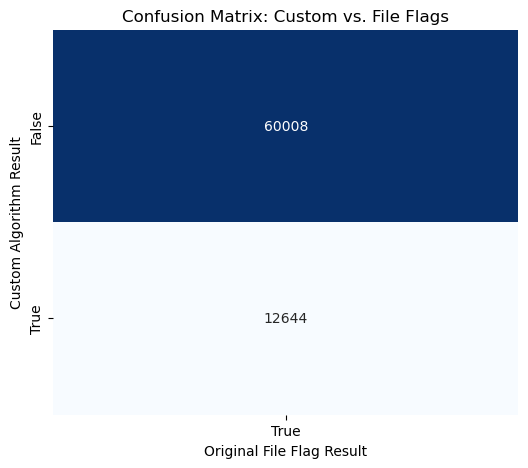

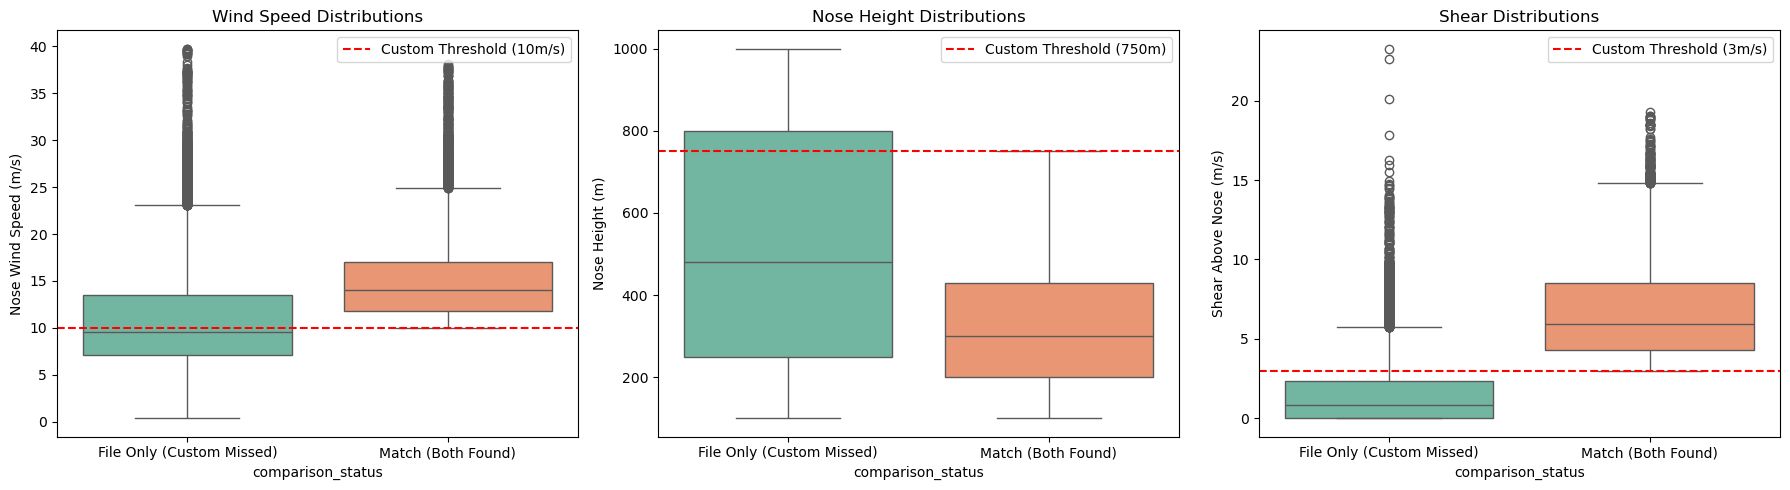


--- DIAGNOSTIC SUMMARY ---
Cases where YOU found a jet but the FILE did not:
       nose_ws_custom  nose_height_custom  shear_custom
count             0.0                 0.0           0.0
mean              NaN                 NaN           NaN
std               NaN                 NaN           NaN
min               NaN                 NaN           NaN
25%               NaN                 NaN           NaN
50%               NaN                 NaN           NaN
75%               NaN                 NaN           NaN
max               NaN                 NaN           NaN


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure you have 'df_jets' from Phase 2 before running this!

# --- 1. CALCULATE AGREEMENT STATISTICS ---
# Create a contingency table (Confusion Matrix)
comparison_matrix = pd.crosstab(df_jets['is_LLJ_custom'], df_jets['is_LLJ_file'], 
                                rownames=['Custom Logic'], colnames=['File Flag'])

print("\n--- COMPARISON MATRIX ---")
print(comparison_matrix)

# Calculate Agreement Percentage
total_points = len(df_jets)
matches = (df_jets['is_LLJ_custom'] == df_jets['is_LLJ_file']).sum()
agreement_pct = (matches / total_points) * 100
print(f"\nOverall Agreement: {agreement_pct:.2f}%")

# --- 2. VISUALIZE THE CONFUSION MATRIX ---
plt.figure(figsize=(6, 5))
sns.heatmap(comparison_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Custom vs. File Flags')
plt.ylabel('Custom Algorithm Result')
plt.xlabel('Original File Flag Result')
plt.show()

# --- 3. DIAGNOSE THE MISMATCHES (The "Why") ---
# Create a 'Status' column to categorize every timestep
df_jets['comparison_status'] = 'No Jet (Both)'
df_jets.loc[(df_jets['is_LLJ_custom'] == True) & (df_jets['is_LLJ_file'] == True), 'comparison_status'] = 'Match (Both Found)'
df_jets.loc[(df_jets['is_LLJ_custom'] == True) & (df_jets['is_LLJ_file'] == False), 'comparison_status'] = 'Custom Only (File Missed)'
df_jets.loc[(df_jets['is_LLJ_custom'] == False) & (df_jets['is_LLJ_file'] == True), 'comparison_status'] = 'File Only (Custom Missed)'

# Filter to only the times where AT LEAST ONE algorithm found a jet
active_events = df_jets[df_jets['comparison_status'] != 'No Jet (Both)'].copy() # Added .copy() to avoid SettingWithCopyWarning

if not active_events.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # A. Compare Nose Wind Speeds
    sns.boxplot(data=active_events, x='comparison_status', y='nose_ws_custom', 
                hue='comparison_status', legend=False, ax=axes[0], palette='Set2')
    axes[0].set_title('Wind Speed Distributions')
    axes[0].set_ylabel('Nose Wind Speed (m/s)')
    axes[0].axhline(MIN_WS_THRESHOLD, color='r', linestyle='--', label='Custom Threshold (10m/s)')
    axes[0].legend()

    # B. Compare Nose Heights
    sns.boxplot(data=active_events, x='comparison_status', y='nose_height_custom', 
                hue='comparison_status', legend=False, ax=axes[1], palette='Set2')
    axes[1].set_title('Nose Height Distributions')
    axes[1].set_ylabel('Nose Height (m)')
    axes[1].axhline(MAX_NOSE_HEIGHT, color='r', linestyle='--', label='Custom Threshold (750m)')
    axes[1].legend()

    # C. Compare Shear
    sns.boxplot(data=active_events, x='comparison_status', y='shear_custom', 
                hue='comparison_status', legend=False, ax=axes[2], palette='Set2')
    axes[2].set_title('Shear Distributions')
    axes[2].set_ylabel('Shear Above Nose (m/s)')
    axes[2].axhline(MIN_SHEAR_ABOVE, color='r', linestyle='--', label='Custom Threshold (3m/s)')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
    
    # Print specific details to help you debug
    print("\n--- DIAGNOSTIC SUMMARY ---")
    print("Cases where YOU found a jet but the FILE did not:")
    print(active_events[active_events['comparison_status'] == 'Custom Only (File Missed)'][['nose_ws_custom', 'nose_height_custom', 'shear_custom']].describe())
else:
    print("No jets found by either algorithm to compare.")

Analyzing 60008 mismatch cases...


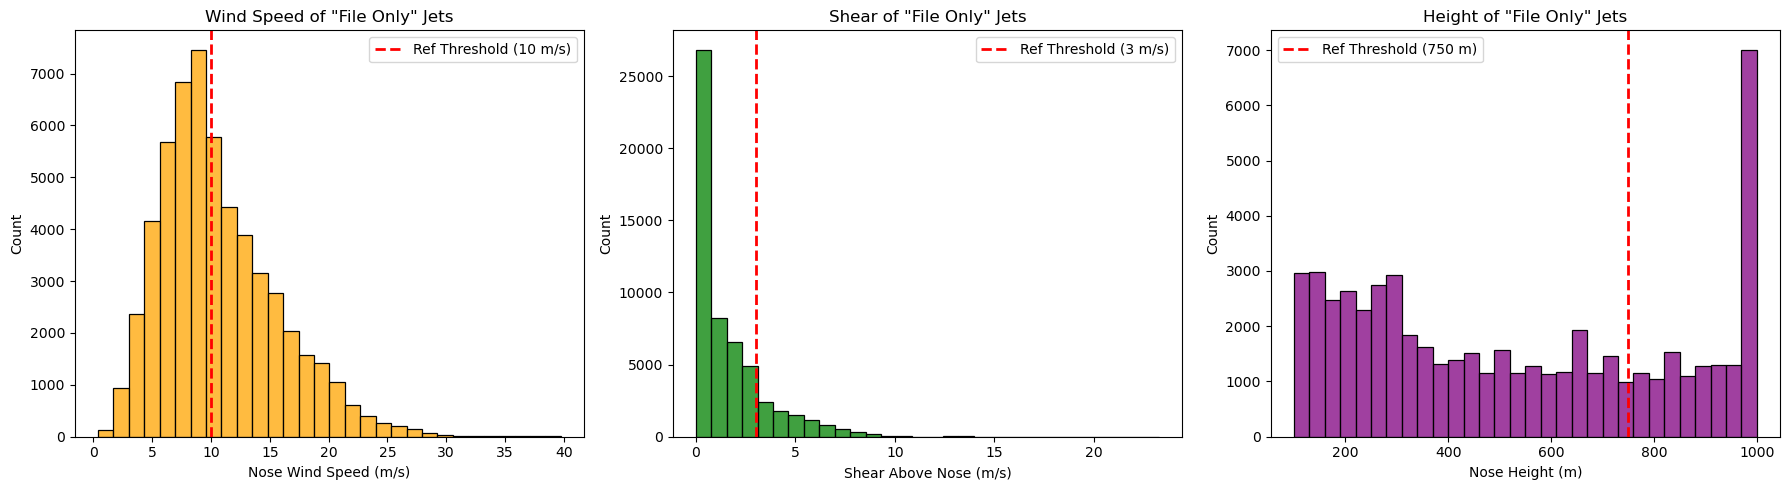


--- WHY DID WE REJECT THESE FILE JETS? ---
Total 'File Only' Jets: 60008
Rejection Reason 1: Speed < 10 m/s:   29980 cases (50.0%)
Rejection Reason 2: Shear < 3 m/s:    46204 cases (77.0%)
Rejection Reason 3: Height > 750 m:   15718 cases (26.2%)
(Note: Percentages may sum > 100% because a jet can fail multiple checks)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for the mismatch cases: File says YES, Reference Code says NO
mismatches = df_jets[
    (df_jets['is_LLJ_file'] == True) & 
    (df_jets['is_LLJ_custom'] == False)
].copy()

print(f"Analyzing {len(mismatches)} mismatch cases...")

# --- DIAGNOSTIC PLOTS ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. Check Wind Speed of the "File Jets"
# If the median is < 10, the file accepts slow jets.
sns.histplot(mismatches['nose_ws_custom'], bins=30, ax=ax[0], color='orange')
ax[0].axvline(10, color='r', linestyle='--', linewidth=2, label='Ref Threshold (10 m/s)')
ax[0].set_title('Wind Speed of "File Only" Jets')
ax[0].set_xlabel('Nose Wind Speed (m/s)')
ax[0].legend()

# 2. Check Shear of the "File Jets"
# If the median is < 3, the file accepts weak shear.
sns.histplot(mismatches['shear_custom'], bins=30, ax=ax[1], color='green')
ax[1].axvline(3, color='r', linestyle='--', linewidth=2, label='Ref Threshold (3 m/s)')
ax[1].set_title('Shear of "File Only" Jets')
ax[1].set_xlabel('Shear Above Nose (m/s)')
ax[1].legend()

# 3. Check Height of the "File Jets"
# If many are > 750, the file accepts high jets.
sns.histplot(mismatches['nose_height_custom'], bins=30, ax=ax[2], color='purple')
ax[2].axvline(750, color='r', linestyle='--', linewidth=2, label='Ref Threshold (750 m)')
ax[2].set_title('Height of "File Only" Jets')
ax[2].set_xlabel('Nose Height (m)')
ax[2].legend()

plt.tight_layout()
plt.show()

# --- PRINT STATS ---
print("\n--- WHY DID WE REJECT THESE FILE JETS? ---")
print(f"Total 'File Only' Jets: {len(mismatches)}")
low_speed = (mismatches['nose_ws_custom'] < 10).sum()
low_shear = (mismatches['shear_custom'] < 3).sum()
too_high = (mismatches['nose_height_custom'] > 750).sum()

print(f"Rejection Reason 1: Speed < 10 m/s:   {low_speed} cases ({low_speed/len(mismatches)*100:.1f}%)")
print(f"Rejection Reason 2: Shear < 3 m/s:    {low_shear} cases ({low_shear/len(mismatches)*100:.1f}%)")
print(f"Rejection Reason 3: Height > 750 m:   {too_high} cases ({too_high/len(mismatches)*100:.1f}%)")
print("(Note: Percentages may sum > 100% because a jet can fail multiple checks)")